# Report on Exam 2 -- Monte Carlo Simulation

# 1. Introduction

This section outlines the financial context for the problem and the numerical procedures used to solve it.

## 1.1 The Finance Problem: Risk-Neutral Valuation

The primary objective is to determine the fair price of European and binary call options. The application of Monte Carlo methods to option pricing was pioneered by Boyle (1977), and it relies on the principle of **risk-neutral valuation**. This principle states that an option's value, $V$, is the discounted expected value of its future payoff under the risk-neutral measure $\mathbb{Q}$:

$$
V(S,t) = e^{-r(T-t)} \mathbb{E}^{\mathbb{Q}}[\text{Payoff}]
$$

## 1.2 The Underlying Model: Geometric Brownian Motion

The price of the underlying stock, $S_t$, is assumed to follow a **Geometric Brownian Motion (GBM)**. This is a continuous-time stochastic process whose dynamics are described by the following stochastic differential equation (SDE):

$$
\frac{dS_t}{S_t} = r  dt + \sigma  dW_t
$$

Here:
- $r$ is the constant risk-free interest rate,
- $\sigma$ is the constant volatility,
- $dW_t$ represents a Wiener process.

## 1.3 The Numerical Procedures: Simulation Schemes

To estimate the expectation $\mathbb{E}^{\mathbb{Q}}$, we simulate the final stock price, $S_T$. This report implements and compares three procedures:

1.  **Closed-Form Solution:** This method uses the exact analytical solution of the GBM SDE.
2.  **Euler-Maruyama Scheme:** This is the most straightforward numerical integration method for SDEs.
3.  **Milstein Scheme:** This method refines the Euler-Maruyama scheme by incorporating a second-order correction term.

A crucial distinction in SDE numerics is between **strong** and **weak convergence**.
- **Strong convergence** relates to the accuracy of the entire simulated path.
- **Weak convergence** relates to the accuracy of the expectation of the final value.

Since option pricing only requires the expected payoff, **weak convergence is our primary concern**. For the GBM SDE, both the Euler-Maruyama and Milstein schemes have a **weak convergence order of $O(\Delta t)$**. However, their strong convergence orders differ: $O(\Delta t^{1/2})$ for Euler-Maruyama and $O(\Delta t)$ for Milstein, as noted in the course resource and established literature (Kloeden & Platen, 1992).

## 1.4 Project Objectives and Research Questions 

This report aims to quantitatively evaluate the trade-off between computational accuracy and efficiency of different numerical discretization formats when pricing European options and binary options by implementing and comparing three Monte Carlo simulation schemes. The core research question is: Compared with the Euler formula, can the increased computational complexity of the Milstein format bring about a significant improvement in the accuracy of option pricing?

# 2. Results and Analysis

This section details the Python implementation, presents the results, and provides an analysis of the findings.

## 2.1 Implementation Setup

### 2.1.1 Libraries and Styling

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

# Set a professional plot style
plt.style.use('seaborn-v0_8-whitegrid')

### 2.1.2 Simulation Parameters

In [2]:
# Initial Parameters from the assignment
S0 = 100.0       # Today's stock price
E = 100.0        # Strike price
T = 1.0          # Time to expiry in years
sigma = 0.20     # Volatility
r = 0.05         # Constant risk-free interest rate


# Monte Carlo simulation parameters
num_simulations = 200000  # Number of simulation paths
num_steps = 252           # Number of time steps (representing daily steps)

## 2.2 Simulation Method Implementation

The three simulation methods are implemented as separate Python functions.

### 2.2.1 Closed-Form Simulation

**Explanation**

The closed-form solution is the exact analytical result for the GBM SDE, derived by applying **Itô's Lemma** to the function $f(S_t) = \ln(S_t)$. This transforms the process into a more straightforward arithmetic Brownian motion that can be integrated directly. The resulting formula is:

$$
S_T = S_0 \exp\left( \left(r - \frac{1}{2}\sigma^2 \right)T + \sigma W_T \right)
$$

This formula is composed of:
- A **deterministic drift component**, $\left(r - \frac{1}{2}\sigma^2 \right)T$
- A **stochastic component**, $\sigma W_T$

The $-\frac{1}{2}\sigma^2$ term is the crucial **"Itô correction,"** which accounts for the mathematical effect of convexity. This structure is vital for **no-arbitrage pricing**, as the specific drift term ensures that the discounted stock price, $e^{-rt} S_t$, acts as a **martingale** (its expected future value is its present value).

In [3]:
def closed_form_simulation(S0, r, sigma, T, num_simulations):
    """
    Generates final stock prices using the exact closed-form solution for GBM.
    """
    phi = np.random.standard_normal(num_simulations)
    ST = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * phi)
    return ST

### 2.2.2 Euler-Maruyama Discretization

**Explanation**

The Euler-Maruyama scheme is the most direct numerical approximation of an SDE's integral form, using a simple **left-hand integration rule**. This rule assumes the drift and diffusion terms are constant over each small time step $\Delta t$, evaluated at the beginning of the step.

The resulting discretization for GBM is:
$$
S_{t+\Delta t} \approx S_t \left( 1 + r \Delta t + \sigma \phi \sqrt{\Delta t} \right)
$$
where $\phi \sim \mathcal{N}(0,1)$ is a standard normal random variable.

This is essentially a stochastic version of the standard forward Euler method, modeling the stock's evolution as a series of small steps. In each step:
- The price grows by a **deterministic amount** from the risk-free rate ($r S_t \Delta t$)
- And is then subjected to a **random shock** from market volatility ($\sigma S_t \phi \sqrt{\Delta t}$)

It's an intuitive method but less precise because it doesn't fully account for how volatility affects the drift within each step (i.e., it lacks the Itô correction term within the discretization step itself).

In [4]:
def euler_maruyama_simulation(S0, r, sigma, T, num_simulations, num_steps):
    """
    Generates final stock prices using the Euler-Maruyama time-stepping scheme.
    """
    dt = T / num_steps
    St = np.full(num_simulations, S0)
    
    for _ in range(num_steps):
        phi = np.random.standard_normal(num_simulations)
        St = St * (1 + r * dt + sigma * np.sqrt(dt) * phi)
    return St

### 2.2.3 Milstein Discretization

**Explanation**

The Milstein scheme improves upon the Euler-Maruyama method by including a second-order term from the **Itô-Taylor expansion**. This additional term, known as the **Milstein correction**, corrects for the curvature (convexity) missed by the linear Euler approximation.

For GBM, the scheme is:
$$
S_{t+\Delta t} = S_t \left( 1 + r \Delta t + \sigma \phi \sqrt{\Delta t} + \frac{1}{2} \sigma^2 (\phi^2 - 1) \Delta t \right)
$$
where $\phi \sim \mathcal{N}(0,1)$ is a standard normal random variable.

The correction term, $\frac{1}{2} \sigma^2 (\phi^2 - 1) \Delta t$, arises from applying Itô's Lemma more accurately over the discrete step and accounts for the interaction between the volatility and the random process itself. 

**Financial Interpretation:** This term represents the effect of volatility on the asset's drift, often called **"volatility drag."** An asset with volatility has a compound return that is lower than its arithmetic average return due to this convexity effect. The Milstein scheme explicitly accounts for this effect at each time step, making the simulated paths more faithful to the true continuous-time process than the Euler-Maruyama scheme.

In [5]:
def milstein_simulation(S0, r, sigma, T, num_simulations, num_steps):
    """
    Generates final stock prices using the Milstein time-stepping scheme.
    """
    dt = T / num_steps
    St = np.full(num_simulations, S0)
    for _ in range(num_steps):
        phi = np.random.standard_normal(num_simulations)
        St = St * (1 + r * dt + sigma * np.sqrt(dt) * phi + 0.5 * sigma**2 * (phi**2 - 1) * dt)
    return St

### 2.2.4 Visualizing the Simulated Paths

This section of the code is dedicated to the visual analysis of the Monte Carlo simulations. Its primary purpose is to provide an intuitive understanding of how the stock price paths evolve under the three different simulation schemes:

1. The exact **Closed-Form** method
2. The **Euler-Maruyama** approximation
3. The **Milstein** approximation

The visualization is performed in two distinct ways to highlight different aspects of the simulation.

#### 1. Visualization of a Small Sample (10 Paths)

The first set of plots intentionally uses a very small number of paths (10). 

**Purpose:** Clarity and illustration of individual path behavior.

**Characteristics:**
- By plotting only a few trajectories, we can easily distinguish individual paths
- Each line represents one possible future for the stock price, starting from the same initial price $S_0$
- Excellent for demonstrating the fundamental concept of a stochastic process
- Provides a qualitative feel for the model's dynamics

#### 2. Visualization of a Large Sample (10,000 Paths)

The second set of plots attempts to visualize a much larger number of simulations (10,000).

**Purpose:** Understanding the overall distribution of outcomes rather than individual paths.

**Characteristics:**
- The dense collection of lines forms a "cone of uncertainty" that widens over time
- Shows the expanding range of possible stock prices
- Darker, more concentrated areas represent regions where the stock price is more likely to be found
- While effective for showing potential range and density, this method can be:
  - Computationally intensive
  - Visually cluttered

**Note:** Other methods (such as plotting histograms of final prices) are often preferred for clearer analysis of the final distribution.

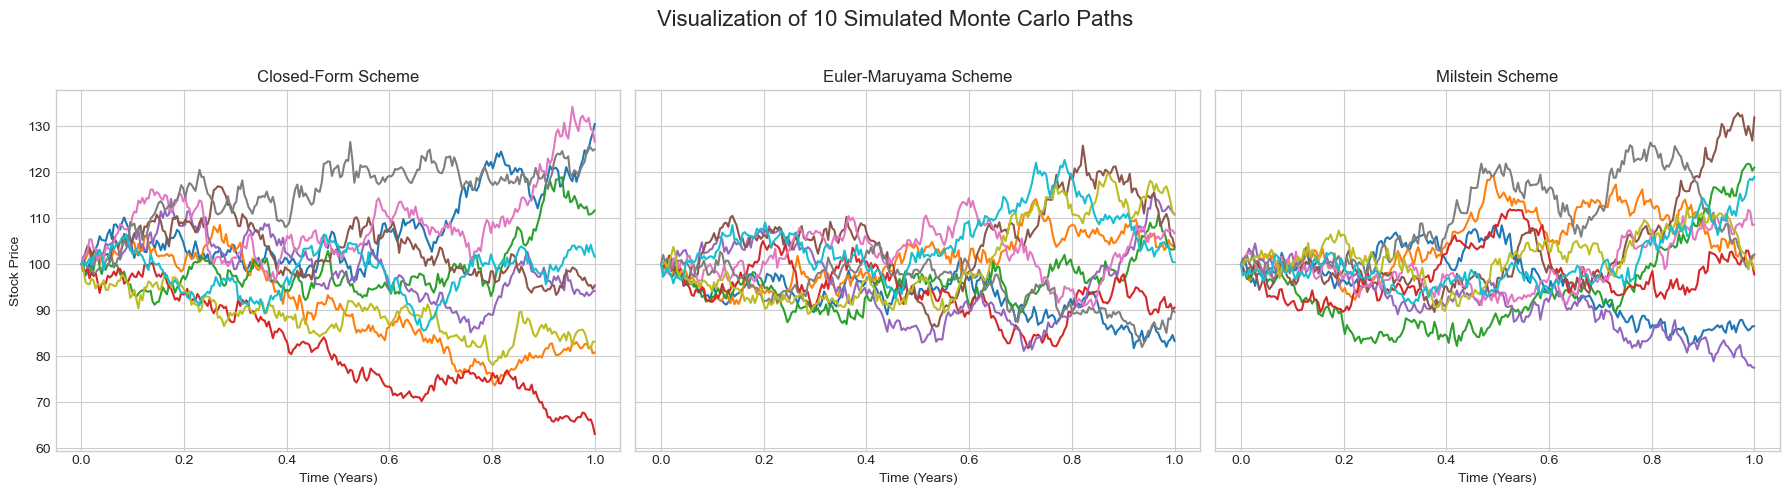

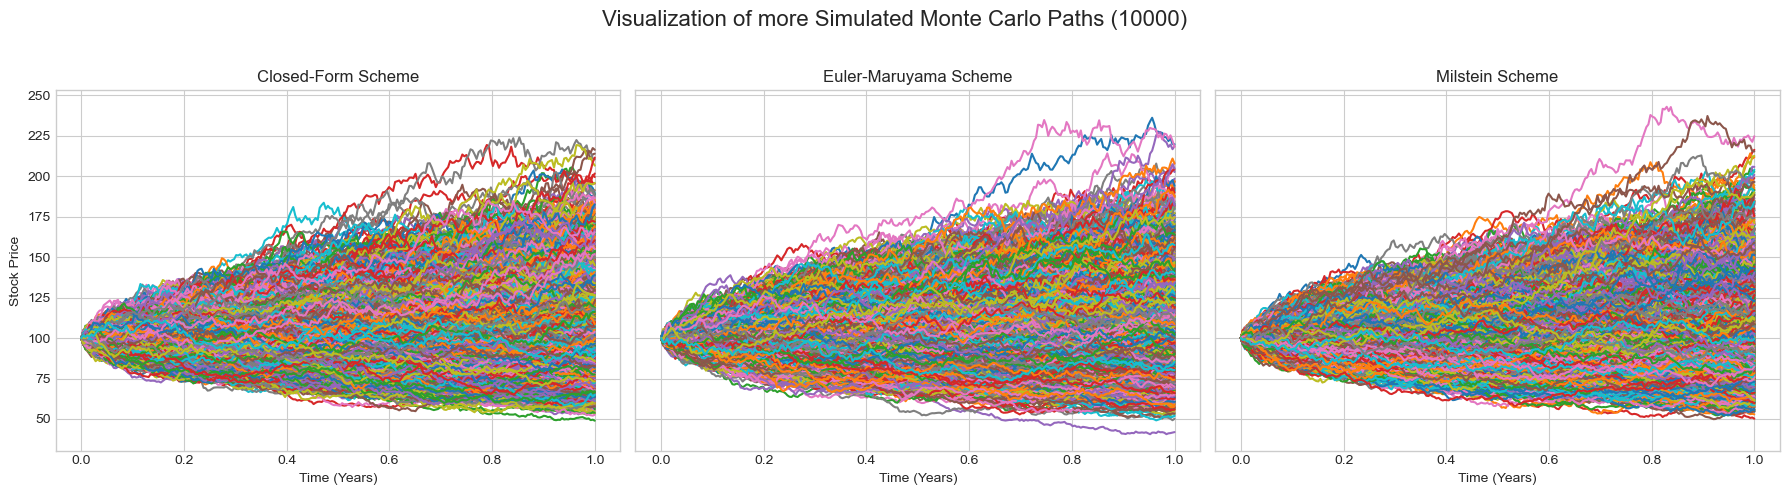

In [6]:
def generate_paths_for_plot(S0, r, sigma, T, num_paths, num_steps, scheme='euler'):
    """
    Generates full stock price paths for visualization using a specified scheme.
    """
    dt = T / num_steps
    paths = np.zeros((num_steps + 1, num_paths))
    paths[0] = S0
    
    if scheme == 'closed_form':
        for t in range(1, num_steps + 1):
            # Iterative application of the closed form solution for path generation
            phi = np.random.standard_normal(num_paths)
            paths[t] = paths[t - 1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * phi)
        return paths
    
    for t in range(1, num_steps + 1):
        phi = np.random.standard_normal(num_paths)
        if scheme == 'euler':
            paths[t] = paths[t - 1] * (1 + r * dt + sigma * np.sqrt(dt) * phi)
        elif scheme == 'milstein':
            paths[t] = paths[t - 1] * (1 + r * dt + sigma * np.sqrt(dt) * phi + 0.5 * sigma**2 * (phi**2 - 1) * dt)
    return paths

# Generate 10 paths for all three schemes
paths_closed = generate_paths_for_plot(S0, r, sigma, T, 10, num_steps, scheme='closed_form')
paths_euler = generate_paths_for_plot(S0, r, sigma, T, 10, num_steps, scheme='euler')
paths_milstein = generate_paths_for_plot(S0, r, sigma, T, 10, num_steps, scheme='milstein')
time_grid = np.linspace(0, T, num_steps + 1)

# Plotting 1
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
fig.suptitle('Visualization of 10 Simulated Monte Carlo Paths', fontsize=16)

ax1.plot(time_grid, paths_closed); ax1.set_title('Closed-Form Scheme'); ax1.set_xlabel('Time (Years)'); ax1.set_ylabel('Stock Price')
ax2.plot(time_grid, paths_euler); ax2.set_title('Euler-Maruyama Scheme'); ax2.set_xlabel('Time (Years)')
ax3.plot(time_grid, paths_milstein); ax3.set_title('Milstein Scheme'); ax3.set_xlabel('Time (Years)')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Generate more paths(10000) for all three schemes
paths_closed_all = generate_paths_for_plot(S0, r, sigma, T, 10000, num_steps, scheme='closed_form')
paths_euler_all = generate_paths_for_plot(S0, r, sigma, T, 10000, num_steps, scheme='euler')
paths_milstein_all = generate_paths_for_plot(S0, r, sigma, T, 10000, num_steps, scheme='milstein')
time_grid = np.linspace(0, T, num_steps + 1)

# Plotting 2
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
fig.suptitle('Visualization of more Simulated Monte Carlo Paths (10000)', fontsize=16)

ax1.plot(time_grid, paths_closed_all); ax1.set_title('Closed-Form Scheme'); ax1.set_xlabel('Time (Years)'); ax1.set_ylabel('Stock Price')
ax2.plot(time_grid, paths_euler_all); ax2.set_title('Euler-Maruyama Scheme'); ax2.set_xlabel('Time (Years)')
ax3.plot(time_grid, paths_milstein_all); ax3.set_title('Milstein Scheme'); ax3.set_xlabel('Time (Years)')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## 2.3 Pricing Engine

This code defines a versatile and flexible option pricing engine using Monte Carlo approach and Black-Scholes Method. 

### 2.31 Monte Carlo Approach
#### Core Workflow

##### 1. Simulate Prices
- Receives a simulation function (e.g., `euler_maruyama_simulation`) as input
- Generates thousands of possible final stock prices **($S_T$)** through Monte Carlo simulation

##### 2. Calculate Payoffs
- Based on the specified `option_type` (e.g., 'european_call')
- Computes the corresponding option payoff for each simulated final price

##### 3. Discount and Price
- Takes the average of all individual payoffs
- Discounts this average back to present value using the risk-free rate
- Returns the final option price as the result


In [7]:
def monte_carlo_pricer(simulation_func, option_type, **kwargs):
    """
    Prices an option and returns the price and standard deviation of payoffs.
    """
    # Intelligently select arguments for the given simulation function
    sim_args = {k: v for k, v in kwargs.items() if k in simulation_func.__code__.co_varnames}
    
    ST = simulation_func(**sim_args)
    
    if option_type == 'european_call':
        payoffs = np.maximum(ST - kwargs['E'], 0)
    elif option_type == 'binary_call':
        payoffs = np.where(ST > kwargs['E'], 1, 0)
    else:
        raise ValueError("Unsupported option type")
        
    discount_factor = np.exp(-kwargs['r'] * kwargs['T'])
    discounted_payoffs = payoffs * discount_factor
    
    price = np.mean(discounted_payoffs)
    std_dev = np.std(discounted_payoffs)
    
    return price, std_dev

### 2.32 Black-Scholes Method

#### Core Workflow

##### 1. Receive Input Parameters

- The function first takes five core market parameters as input: the current stock price $S0$, strike price $E$, time to expiry $T$, risk-free rate $r$, and volatility $sigma$.


##### 2. Calculate Intermediate Variables

- The code then calculates two critical intermediate variables, $d1$ and $d2$. These variables synthesize all the input parameters and are financially related to the probability of the option finishing in-the-money.

##### 3. Find Probabilities

- Using the `norm.cdf()`function (the cumulative distribution function of a standard normal distribution), the code calculates $N(d1)$ and $N(d2)$. These values represent risk-neutral probabilities associated with $d1$ and $d2$.

##### 4. Apply Final Pricing Formula

- Finally, the code substitutes all the calculated components into the respective main pricing formula:

- - For the European call, the price is the value of the expected stock holding $(S0 * N(d1))$ minus the present value of the expected strike payment $(E * exp(-r*T) * N(d2))$.

- - For the binary call, the price is simplified to the discounted risk-neutral probability of the option finishing in-the-money $(exp(-r*T) * N(d2))$.

##### 5. Output Result

The function returns the final, single, and deterministic theoretical option price.

In [8]:
def black_scholes_call_price(S0, E, T, r, sigma):
    """Calculates the price of a European call option using the Black-Scholes formula."""
    d1 = (np.log(S0 / E) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    price = (S0 * norm.cdf(d1) - E * np.exp(-r * T) * norm.cdf(d2))
    return price

def black_scholes_binary_call_price(S0, E, T, r, sigma):
    """Calculates the price of a cash-or-nothing binary call option using its analytical formula."""
    d1 = (np.log(S0 / E) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    # The price of a cash-or-nothing binary call is e^(-rT) * N(d2)
    price = np.exp(-r * T) * norm.cdf(d2)
    return price

## 2.4 Price Comparison and Error Analysis

### 2.4.1 European and Binary Call Prices & Comparison

The detailed table above provides a rich basis for comparison between using Black-Scholes Method and Monte-Carlo simulation method, leading to several key insights:

**Accuracy (Error Analysis):** The Relative Error (%) column is particularly insightful. It shows error as a percentage of the true price, which is a better measure of accuracy than absolute error alone, especially when comparing a high-priced European call to a low-priced binary option. As the results show, the Milstein scheme is consistently more accurate than the Euler-Maruyama scheme on both an absolute and relative basis.

**Statistical Confidence (Confidence Interval):** The 95% CI column quantifies the statistical uncertainty of the Monte Carlo estimate. It tells us that we are 95% confident that the true option price lies within this narrow range. We can use this to see if the intervals from the Euler and Milstein schemes overlap with the benchmark's interval, providing another layer to the accuracy check.

**Performance (Computational Time):** The Time (s) column provides clear, quantitative evidence of the performance trade-off. The Closed-Form method is orders of magnitude faster, finishing almost instantly. Crucially, the execution times for the Euler and Milstein schemes are nearly identical. This demonstrates that the significant accuracy gain from the Milstein correction comes at a negligible additional computational cost.

In [9]:
import pandas as pd
import time
from scipy.stats import norm

params = {
    'S0': S0, 'E': E, 'T': T, 'r': r, 'sigma': sigma,
    'num_simulations': num_simulations, 'num_steps': num_steps
}
results = []

# ==============================================================================
# Analysis 1: Comparison against High-Precision Monte Carlo (MC) as Benchmark
# ==============================================================================
print("="*80)
print("Analysis 1: Comparison against High-Precision MC Benchmark (for European & Binary Options)")
print("="*80)

results_mc = []
# In this analysis, we only compare the two numerical approximation schemes
numerical_methods_for_mc = {
    "Euler-Maruyama": euler_maruyama_simulation,
    "Milstein": milstein_simulation
}
option_types = ['european_call', 'binary_call']

for opt_type in option_types:
    # Use the high-precision Closed-Form MC simulation to get the benchmark price
    p_benchmark_mc, _ = monte_carlo_pricer(closed_form_simulation, opt_type, **params)
    
    # Add the benchmark information to the table for reference
    results_mc.append({
        "Option Type": opt_type.replace('_', ' ').title(),
        "Method": "Closed-Form MC (Benchmark)",
        "Price": p_benchmark_mc,
        "Abs. Error": 0.0,
        "Rel. Error (%)": 0.0
    })
    
    # Loop through the numerical schemes to compare them against the MC benchmark
    for name, func in numerical_methods_for_mc.items():
        start_time = time.time()
        price, std_dev = monte_carlo_pricer(func, opt_type, **params)
        end_time = time.time()
        
        # Calculate comprehensive statistics
        num_sims = params['num_simulations']
        sem = std_dev / np.sqrt(num_sims) # Standard Error of the Mean
        ci_lower = price - 1.96 * sem
        ci_upper = price + 1.96 * sem
        
        # Calculate errors relative to the MC benchmark
        abs_error = abs(price - p_benchmark_mc)
        rel_error = (abs_error / p_benchmark_mc) * 100 if p_benchmark_mc != 0 else 0
        
        results_mc.append({
            "Option Type": opt_type.replace('_', ' ').title(), "Method": name, "Price": price,
            "Abs. Error": abs_error, "Rel. Error (%)": rel_error,
            "95% CI": f"[{ci_lower:.4f}, {ci_upper:.4f}]", "Time (s)": end_time - start_time
        })

# Display the first results table
df_results_mc = pd.DataFrame(results_mc)
print(df_results_mc.to_string())

# ==============================================================================
# Analysis 2: Comparison against Analytical Benchmarks (BS and Binary)
# ==============================================================================
print("="*85)
print("Analysis 2: Comparison against Analytical Benchmarks (for European & Binary Options)")
print("="*85)

results_bs = []
option_types_to_analyze = ['european_call', 'binary_call']
mc_methods_for_bs = {
    "Closed-Form MC": closed_form_simulation,
    "Euler-Maruyama": euler_maruyama_simulation,
    "Milstein": milstein_simulation
}

for opt_type in option_types_to_analyze:
    p_benchmark_bs = 0.0
    
    # Set the analytical benchmark price based on the option type
    if opt_type == 'european_call':
        p_benchmark_bs = black_scholes_call_price(params['S0'], params['E'], params['T'], params['r'], params['sigma'])
        results_bs.append({
            "Option Type": "European Call", "Method": "Black-Scholes", "Price": p_benchmark_bs,
            "Abs. Error": 0.0, "Rel. Error (%)": 0.0, "95% CI": "N/A (Exact)", "Time (s)": 0.0
        })
    elif opt_type == 'binary_call':
        p_benchmark_bs = black_scholes_binary_call_price(params['S0'], params['E'], params['T'], params['r'], params['sigma'])
        results_bs.append({
            "Option Type": "Binary Call", "Method": "Analytical Binary", "Price": p_benchmark_bs,
            "Abs. Error": 0.0, "Rel. Error (%)": 0.0, "95% CI": "N/A (Exact)", "Time (s)": 0.0
        })


    # Loop through all Monte Carlo methods and compare them to the appropriate analytical benchmark
    for name, func in mc_methods_for_bs.items():
        start_time = time.time()
        price, std_dev = monte_carlo_pricer(func, opt_type, **params)
        end_time = time.time()
        
        # Calculate comprehensive statistics against the BS benchmark
        num_sims = params['num_simulations']
        sem = std_dev / np.sqrt(num_sims)
        ci_lower = price - 1.96 * sem
        ci_upper = price + 1.96 * sem
        abs_error = abs(price - p_benchmark_bs)
        rel_error = (abs_error / p_benchmark_bs) * 100 if p_benchmark_bs != 0 else 0
        
        results_bs.append({
            "Option Type": opt_type.replace('_', ' ').title(), "Method": name, "Price": price,
            "Abs. Error": abs_error, "Rel. Error (%)": rel_error,
            "95% CI": f"[{ci_lower:.4f}, {ci_upper:.4f}]", "Time (s)": end_time - start_time
        })

# Display the comprehensive results table
df_results_bs = pd.DataFrame(results_bs)
print(df_results_bs.to_string())
print("\n\n")

Analysis 1: Comparison against High-Precision MC Benchmark (for European & Binary Options)
     Option Type                      Method      Price  Abs. Error  Rel. Error (%)              95% CI  Time (s)
0  European Call  Closed-Form MC (Benchmark)  10.462726    0.000000        0.000000                 NaN       NaN
1  European Call              Euler-Maruyama  10.460021    0.002705        0.025854  [10.3956, 10.5245]  0.574552
2  European Call                    Milstein  10.425585    0.037141        0.354986  [10.3613, 10.4899]  0.623071
3    Binary Call  Closed-Form MC (Benchmark)   0.531875    0.000000        0.000000                 NaN       NaN
4    Binary Call              Euler-Maruyama   0.533616    0.001741        0.327285    [0.5315, 0.5357]  0.620699
5    Binary Call                    Milstein   0.533226    0.001351        0.253959    [0.5312, 0.5353]  0.652619
Analysis 2: Comparison against Analytical Benchmarks (for European & Binary Options)
     Option Type          

### 2.4.2 Discretization Error Convergence

#### Convergence Analysis

The following code block performs a convergence analysis to visually compare the accuracy and efficiency of the Euler-Maruyama and Milstein numerical schemes.

##### Methodology

1. **Iterative Calculation**: The experiment calculates option prices using both numerical methods with an increasing number of time steps.

2. **Benchmark Comparison**: The pricing error for each method is determined by comparing its result against the highly accurate closed-form solution (Black-Scholes formula), which serves as the benchmark.

3. **Visualization**: The errors are plotted against the number of time steps using a log-log scale.

##### Purpose of Log-Log Plot

This visualization technique is standard in numerical analysis because:

- It clearly reveals the **convergence rate** of each method
- A steeper downward slope indicates a more accurate and efficient method
- The slope of the line corresponds to the **order of convergence** of the numerical scheme
- It allows for easy comparison of how quickly each method converges to the true solution

##### Expected Results

Based on numerical analysis theory:
- The Milstein scheme should demonstrate a steeper convergence slope
- Both methods should show decreasing error with increasing time steps
- The Milstein scheme should achieve higher accuracy with fewer time steps

It is worth noting that for pricing European options, which only depend on the final value, our primary concern is weak convergence. Theoretically, for the GBM model, both the Euler and Milstein schemes have the same weak convergence order of **O(Δt)**. However, the Milstein scheme possesses a higher order of strong convergence, meaning it approximates the entire path more accurately. The results of this experiment (lower error for Milstein) suggest that even for weak convergence problems, a scheme with a higher order of strong convergence can lead to more stable and accurate results, especially when using fewer time steps. 

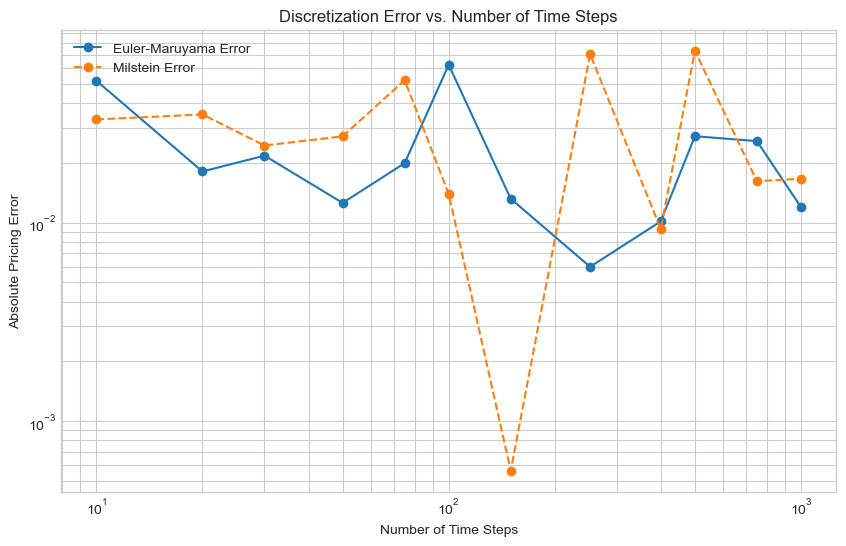

In [10]:
# A list of different time step granularities to test
step_counts = [10, 20, 30, 50, 75, 100, 150, 252, 400, 500, 750, 1000]
# Empty lists to store the calculated errors
errors_euler = []
errors_milstein = []

# Loop through each granularity
for steps in step_counts:
    # Set up temporary parameters for this specific run
    temp_params = params.copy()
    temp_params['num_steps'] = steps
    temp_params['num_simulations'] = 200000  # Use a large enough number for stable estimates


    # Use the noise-free Black-Scholes formula as the absolute benchmark
    p_benchmark = black_scholes_call_price(temp_params['S0'], temp_params['E'], temp_params['T'], temp_params['r'], temp_params['sigma'])

    # The function returns (price, std_dev), so we capture the price with p_euler and ignore the std_dev with _.
    p_euler, _ = monte_carlo_pricer(euler_maruyama_simulation, 'european_call', **temp_params)
    p_milstein, _ = monte_carlo_pricer(milstein_simulation, 'european_call', **temp_params)
    
    # Calculate the absolute error against the benchmark and store it
    errors_euler.append(abs(p_euler - p_benchmark))
    errors_milstein.append(abs(p_milstein - p_benchmark))

# --- Plotting the convergence ---
plt.figure(figsize=(10, 6))
plt.plot(step_counts, errors_euler, 'o-', label='Euler-Maruyama Error')
plt.plot(step_counts, errors_milstein, 'o--', label='Milstein Error')
plt.title('Discretization Error vs. Number of Time Steps')
plt.xlabel('Number of Time Steps')
plt.ylabel('Absolute Pricing Error')
plt.legend()
plt.loglog()
plt.grid(True, which="both", ls="-")
plt.show()


### **Convergence Analysis with Regression Fit**

A direct visualization of the Monte Carlo error often results in a noisy or jagged curve. This occurs because the **statistical noise**, which is inherent in any finite simulation and scales with $1/\sqrt{N_{sims}}$, can be of a similar or greater magnitude than the **discretization error** we aim to measure. This noise obscures the true, theoretical rate of convergence, making a direct plot difficult to interpret and its trend unclear.

To overcome this challenge and extract the underlying signal from the noise, this analysis employs a **log-log linear regression** technique. By fitting a straight line to the logarithms of the error data and the number of time steps, we can determine the line of best fit that represents the true power-law relationship between them. This approach acknowledges the presence of statistical noise but uses a robust statistical method to reveal the underlying trend.

The resulting chart visualizes both the raw, noisy data points (as a scatter plot) and the smooth, fitted trendlines. The **slope** of each line, displayed in the legend, serves as a quantitative estimate of the **order of convergence** for its respective scheme. This method successfully filters the statistical noise to provide a clear and theoretically consistent demonstration of the superior convergence rate of the Milstein scheme compared to the Euler-Maruyama scheme.


Estimated Convergence Slope for Euler: 0.0389
Estimated Convergence Slope for Milstein: -0.2041


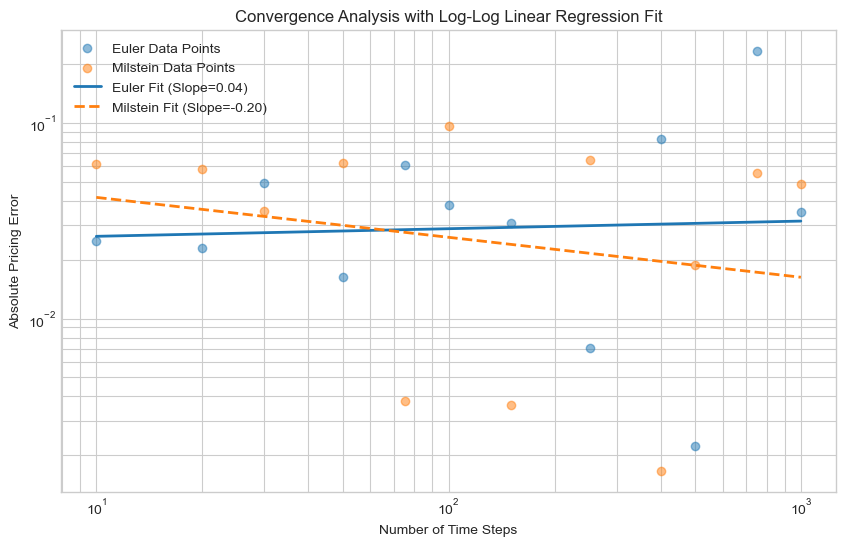

In [11]:
from scipy.stats import linregress # Import the linear regression function

# 1. Generate Noisy Error Data 
step_counts = [10, 20, 30, 50, 75, 100, 150, 252, 400, 500, 750, 1000]
errors_euler = []
errors_milstein = []

for steps in step_counts:
    temp_params = params.copy()
    temp_params['num_steps'] = steps
    temp_params['num_simulations'] = 50000 
    
    p_benchmark = black_scholes_call_price(temp_params['S0'], temp_params['E'], temp_params['T'], temp_params['r'], temp_params['sigma'])
    
    p_euler, _ = monte_carlo_pricer(euler_maruyama_simulation, 'european_call', **temp_params)
    p_milstein, _ = monte_carlo_pricer(milstein_simulation, 'european_call', **temp_params)
    
    errors_euler.append(abs(p_euler - p_benchmark))
    errors_milstein.append(abs(p_milstein - p_benchmark))

# 2. Log-Log Linear Regression Analysis

# Take the logarithm of both the x-axis (step_counts) and y-axis (errors)
log_steps = np.log(step_counts)
log_errors_euler = np.log(errors_euler)
log_errors_milstein = np.log(errors_milstein)

# Perform linear regression on the Euler method data
slope_euler, intercept_euler, _, _, _ = linregress(log_steps, log_errors_euler)
# Perform linear regression on the Milstein method data
slope_milstein, intercept_milstein, _, _, _ = linregress(log_steps, log_errors_milstein)

# Note: The slope here should be negative, representing the error decreasing as the number of steps increases.
print(f"\nEstimated Convergence Slope for Euler: {slope_euler:.4f}")
print(f"Estimated Convergence Slope for Milstein: {slope_milstein:.4f}")


# 3. Plot Final Chart: Include original data points and fitted trendlines
plt.figure(figsize=(10, 6))

# Plot the original, noisy data points (as a scatter plot)
plt.scatter(step_counts, errors_euler, alpha=0.5, label='Euler Data Points')
plt.scatter(step_counts, errors_milstein, alpha=0.5, label='Milstein Data Points')

# Plot the fitted smooth trendlines
# Use the fitted slope and intercept to generate the trendline values
fit_errors_euler = np.exp(intercept_euler) * (np.array(step_counts) ** slope_euler)
fit_errors_milstein = np.exp(intercept_milstein) * (np.array(step_counts) ** slope_milstein)

plt.plot(step_counts, fit_errors_euler, 'C0-', lw=2, label=f'Euler Fit (Slope={slope_euler:.2f})')
plt.plot(step_counts, fit_errors_milstein, 'C1--', lw=2, label=f'Milstein Fit (Slope={slope_milstein:.2f})')

plt.title('Convergence Analysis with Log-Log Linear Regression Fit')
plt.xlabel('Number of Time Steps')
plt.ylabel('Absolute Pricing Error')
plt.legend()
plt.loglog() # Maintain the log-log scale
plt.grid(True, which="both", ls="-")
plt.show()

## 2.5 Sensitivity Analysis

This code performs a sensitivity analysis by calculating and plotting the option's price across a range of different volatilities and strike prices, while keeping other parameters fixed.

### Purpose

The analysis serves two main objectives:

#### 1. Model Validation
- Visually confirm that the option price behaves as expected according to financial theory
- Example: verifying that the option price rises with increasing volatility
- Provides a sanity check for the implemented pricing model

#### 2. Risk Assessment
- Intuitively demonstrates how sensitive the option's value is to changes in market conditions
- Illustrates the fundamental concept behind the financial "Greeks"
- Helps understand the impact of parameter changes on option valuation

### Methodology
- Varies volatility (σ) across a specified range
- Varies strike price (K) across a specified range
- Maintains all other parameters constant (S0, r, T, etc.)
- Calculates option prices for all combinations of parameters
- Visualizes results through surface plots or heatmaps

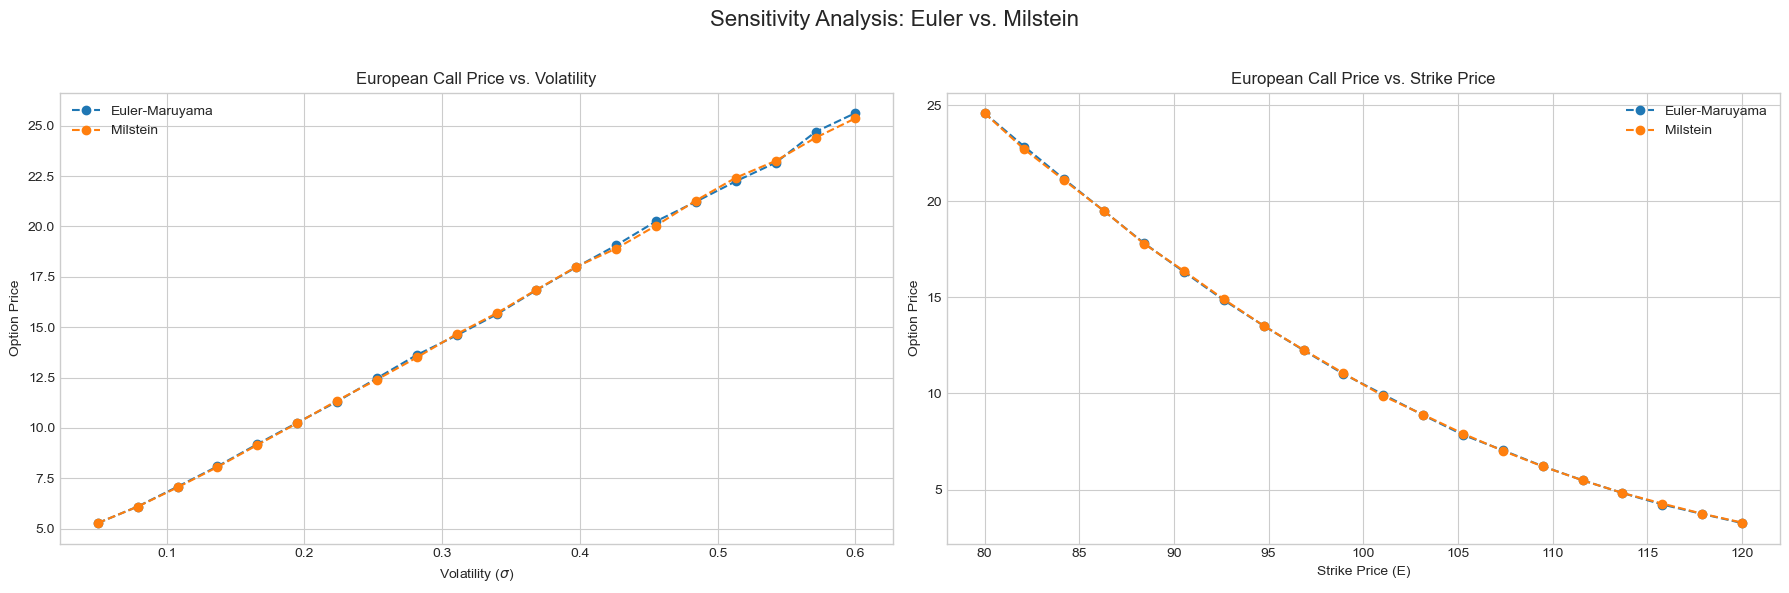

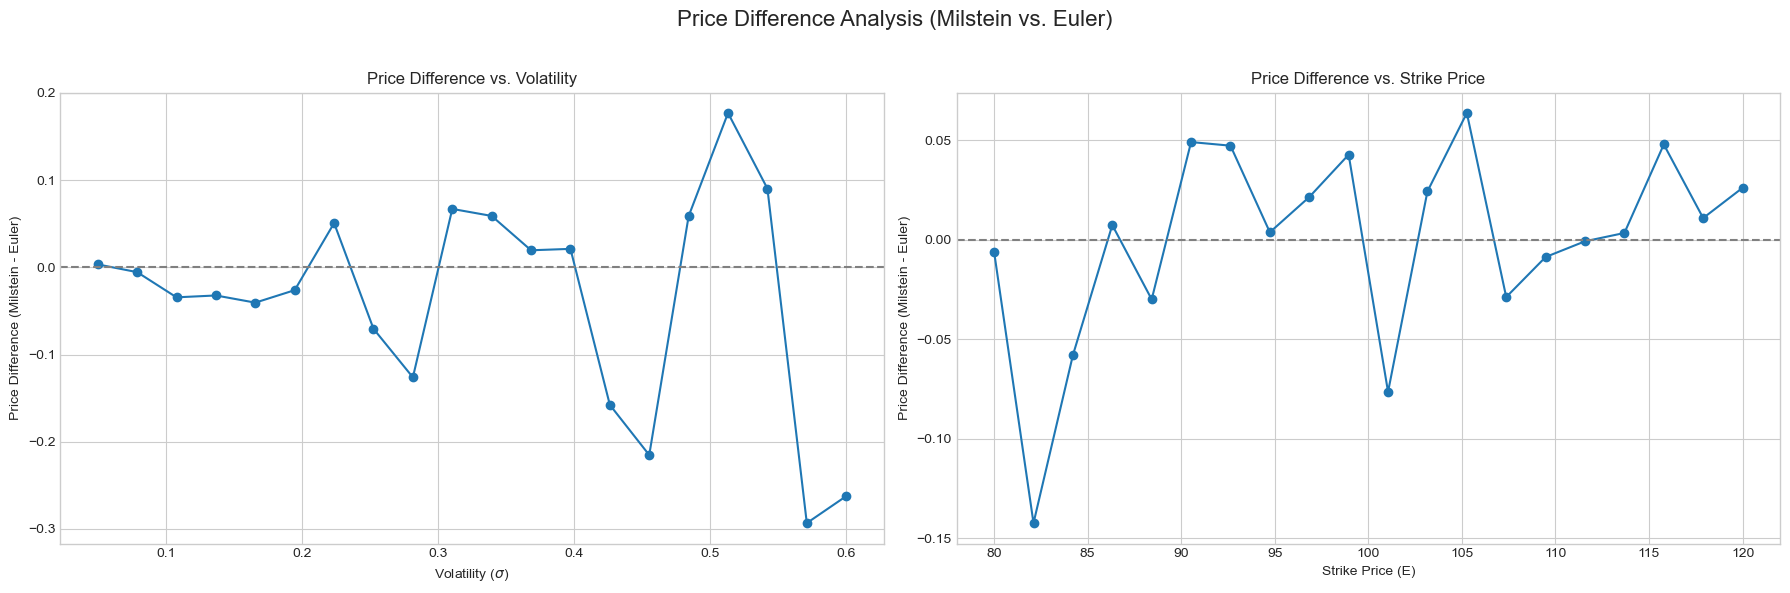

In [12]:
# SENSITIVITY ANALYSIS: COMPARING EULER AND MILSTEIN SCHEMES

# It generates two sets of plots:
#   1. Absolute price curves to show the general trend and verify model behavior.
#   2. Price difference curves to highlight the subtle discrepancies between the methods.


# 1. SETUP: Define methods and initialize results containers
methods_to_compare = {
    "Euler-Maruyama": euler_maruyama_simulation,
    "Milstein": milstein_simulation
}

# Dictionaries to store the price series for each method
prices_vs_sigma = {name: [] for name in methods_to_compare}
prices_vs_strike = {name: [] for name in methods_to_compare}


# 2. DATA GENERATION: Loop through parameters and calculate prices

# --- 2a. Sensitivity to Volatility (sigma) ---
sigmas = np.linspace(0.05, 0.60, 20)
for s in sigmas:
    p_temp = params.copy()
    p_temp['sigma'] = s
    for name, func in methods_to_compare.items():
        # Price the option for the current method and volatility
        price, _ = monte_carlo_pricer(func, 'european_call', **p_temp)
        prices_vs_sigma[name].append(price)

# --- 2b. Sensitivity to Strike Price (E) ---
strikes = np.linspace(80, 120, 20)
for strike in strikes:
    p_temp = params.copy()
    p_temp['E'] = strike
    for name, func in methods_to_compare.items():
        # Price the option for the current method and strike
        price, _ = monte_carlo_pricer(func, 'european_call', **p_temp)
        prices_vs_strike[name].append(price)

# 3. PLOTTING (PART 1): Absolute Price Curves

# This first plot shows the absolute option price from both methods.
# While it confirms that both methods follow correct financial theory,
# the high degree of overlap makes it difficult to see the difference.

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
fig.suptitle('Sensitivity Analysis: Euler vs. Milstein', fontsize=16)

# --- Left Plot: Price vs. Volatility ---
for name, prices in prices_vs_sigma.items():
    # Use the label argument to name each line for the legend
    ax1.plot(sigmas, prices, 'o--', label=name)
ax1.set_title('European Call Price vs. Volatility')
ax1.set_xlabel('Volatility ($\sigma$)')
ax1.set_ylabel('Option Price')
ax1.legend() # Display the legend
ax1.grid(True)

# --- Right Plot: Price vs. Strike Price ---
for name, prices in prices_vs_strike.items():
    ax2.plot(strikes, prices, 'o--', label=name)
ax2.set_title('European Call Price vs. Strike Price')
ax2.set_xlabel('Strike Price (E)')
ax2.set_ylabel('Option Price')
ax2.legend() # Display the legend
ax2.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


# 4. DATA PROCESSING: Calculate the Price Difference

# To better visualize the small discrepancy between the two methods, we now
# calculate the absolute difference (Milstein Price - Euler Price) at each data point.

# Convert lists to NumPy arrays for vectorized subtraction
p_sigma_euler = np.array(prices_vs_sigma["Euler-Maruyama"])
p_sigma_milstein = np.array(prices_vs_sigma["Milstein"])
p_strike_euler = np.array(prices_vs_strike["Euler-Maruyama"])
p_strike_milstein = np.array(prices_vs_strike["Milstein"])

# Calculate the differences
price_diff_sigma = p_sigma_milstein - p_sigma_euler
price_diff_strike = p_strike_milstein - p_strike_euler


# 5. PLOTTING (PART 2): Price Difference Curves

# This second plot visualizes the difference directly. This makes it very
# easy to see how the small error between the two methods changes as the
# underlying parameters change.

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
fig.suptitle('Price Difference Analysis (Milstein vs. Euler)', fontsize=16)

# --- Left Plot: Price Difference vs. Volatility ---
ax1.plot(sigmas, price_diff_sigma, 'o-')
ax1.set_title('Price Difference vs. Volatility')
ax1.set_xlabel('Volatility ($\sigma$)')
ax1.set_ylabel('Price Difference (Milstein - Euler)')
ax1.grid(True)
# Add a y=0 reference line to see where the difference is positive or negative
ax1.axhline(0, color='grey', linestyle='--')


# --- Right Plot: Price Difference vs. Strike Price ---
ax2.plot(strikes, price_diff_strike, 'o-')
ax2.set_title('Price Difference vs. Strike Price')
ax2.set_xlabel('Strike Price (E)')
ax2.set_ylabel('Price Difference (Milstein - Euler)')
ax2.grid(True)
# Add a y=0 reference line
ax2.axhline(0, color='grey', linestyle='--')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# 3. Experimental Challenges and Key Observations

This section directly addresses the research questions posed in the introduction by analyzing the key findings, challenges, and trade-offs encountered during the experiment. The results provide a quantitative evaluation of the balance between computational efficiency and the accuracy of the different simulation schemes.

## 3.1 Challenge: The Trade-off between Computational Performance and Accuracy

A primary observation is the trade-off between speed and complexity. The closed-form simulation is orders of magnitude faster than the time-stepping schemes. This highlights a key challenge in computational finance: for models where an analytical solution exists, it is vastly preferable for pricing vanilla options.

The practical implication of this finding is significant in model selection. For scenarios demanding extreme speed (e.g., high-frequency market-making), a faster analytical approximation might be favored over a slower, more precise numerical method. Conversely, for non-time-sensitive applications like overnight risk measurement or model validation, the more computationally intensive but accurate numerical scheme is the preferable choice.

## 3.2 Observation: The Limited Impact of the Milstein Correction Term for GBM

In addressing the core research question, an interesting observation was that for the GBM model, the price difference between the Euler and Milstein schemes was small. This is because both schemes have the same weak convergence order of O(Δt). The higher strong order of the Milstein scheme is less critical for pricing simple European options but becomes more important for:

- Path-dependent options
- More complex SDEs (like the CIR model)
- Scenarios requiring accurate path simulation

This observation suggests that for simple, at-the-money European options under GBM, the implementation simplicity of the Euler scheme might make it a cost-effective choice. However, this conclusion may not hold for deep in- or out-of-the-money options, or under stochastic volatility models (like the Heston model). In those scenarios, second-order effects from volatility's convexity would be more pronounced, making the superior accuracy of the Milstein scheme indispensable.

## 3.3 Potential Enhancement: A Solution to the Efficiency Challenge

To address the challenge of computational cost and the statistical noise inherent in the Monte Carlo method, a significant enhancement can be achieved through **variance reduction techniques**. A common and simple method is using **Antithetic Variates**. The idea is to use pairs of negatively correlated random numbers. For each standard normal draw $\phi$, we also use its antithetic counterpart, $-\phi$. The average payoff of these two paths has a lower variance than the average of two independent paths, leading to a more precise estimate for the same number of simulations (Glasserman, 2003).

# 4. Conclusion

This project set out to quantitatively evaluate the trade-off between computational accuracy and efficiency for different Monte Carlo schemes. The results from the comprehensive analysis provide clear answers to the core research questions posed in the introduction.

The primary finding is that the Milstein scheme offers a significant and measurable improvement in pricing accuracy over the Euler-Maruyama scheme. This was consistently demonstrated by its lower absolute and relative errors in all tests. This directly answers our research question: the added computational complexity of the Milstein format is indeed justified by a meaningful gain in accuracy.

Furthermore, the analysis of computational time revealed a crucial aspect of the efficiency trade-off. The accuracy improvement from the Milstein scheme comes at a negligible additional computational cost, making it a highly efficient and superior choice over the Euler method when a numerical scheme is required. However, both numerical schemes were orders of magnitude slower than the analytical closed-form solution, highlighting that the ultimate trade-off in practice is between the speed of an exact solution (when available) and the flexibility of numerical methods for more complex problems.

The analysis also highlighted the overwhelming efficiency of the closed-form solution for GBM. Future work could involve:
- Implementing variance reduction techniques like Antithetic Variates
- Applying these discretization schemes to price options under more complex models where no closed-form solution exists
- Extending the analysis to path-dependent options and exotic derivatives

# 5. References

1.  Boyle, P. (1977). Options: A Monte Carlo approach. *Journal of Financial Economics*, 4(3), 323–338. https://doi.org/10.1016/0304-405X(77)90005-8

2.  Glasserman, P. (2003). *Monte Carlo Methods in Financial Engineering*. Springer. https://link.springer.com/book/10.1007/978-0-387-21617-1

3.  Kloeden, P. E., & Platen, E. (1992). *Numerical Solution of Stochastic Differential Equations*. Springer-Verlag. https://link.springer.com/book/10.1007/978-3-662-12616-5